In [2]:
import pandas as pd

df = pd.read_csv("covid_jakbar.csv")
num_cols = ["Konfirmasi_Positif","Konfirmasi_Meninggal","Konfirmasi_Isolasi_Mandiri"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="raise")
df.head(), df.describe()


(    Kecamatan           Kelurahan  Konfirmasi_Positif  Konfirmasi_Meninggal  \
 0  Cengkareng    Cengkareng Barat                8676                   120   
 1  Cengkareng    Cengkareng Timur                8926                   119   
 2  Cengkareng        Duri Kosambi                7437                    88   
 3  Cengkareng               Kapuk                9480                   189   
 4  Cengkareng  Kedaung Kali Angke                3146                    39   
 
    Konfirmasi_Isolasi_Mandiri  
 0                         104  
 1                          89  
 2                          81  
 3                          62  
 4                          32  ,
        Konfirmasi_Positif  Konfirmasi_Meninggal  Konfirmasi_Isolasi_Mandiri
 count           31.000000             31.000000                   31.000000
 mean          5377.774194             68.129032                   75.354839
 std           2232.926476             35.422913                   38.693280
 min       

In [3]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X = df[["Konfirmasi_Positif","Konfirmasi_Meninggal","Konfirmasi_Isolasi_Mandiri"]].values

def run_kmeans(X, k, seed=42):
    km = KMeans(
        n_clusters=k,
        init="random",   # centroid awal acak (sesuai soal)
        n_init=10,       # beberapa inisialisasi → lebih stabil
        max_iter=1000,
        random_state=seed
    )
    labels = km.fit_predict(X)
    return km, labels, km.cluster_centers_

results = {}
for k in [2,3,4]:
    km, labels, centers = run_kmeans(X, k)
    results[k] = {"model": km, "labels": labels, "centers": centers}

def summarize(k):
    centers = results[k]["centers"]
    labels  = results[k]["labels"]
    rows = []
    for j, c in enumerate(centers):
        rows.append({
            "k": k, "cluster": j,
            "members": int((labels==j).sum()),
            "centroid_Positif": round(float(c[0]),3),
            "centroid_Meninggal": round(float(c[1]),3),
            "centroid_Isoman": round(float(c[2]),3),
            "centroid_Total": round(float(c.sum()),3)
        })
    return pd.DataFrame(rows).sort_values("centroid_Total", ascending=True).reset_index(drop=True)

sum_k2 = summarize(2)
sum_k3 = summarize(3)
sum_k4 = summarize(4)

sum_k2, sum_k3, sum_k4


(   k  cluster  members  centroid_Positif  centroid_Meninggal  centroid_Isoman  \
 0  2        0       21          4026.524              48.905           60.905   
 1  2        1       10          8215.400             108.500          105.700   
 
    centroid_Total  
 0        4136.333  
 1        8429.600  ,
    k  cluster  members  centroid_Positif  centroid_Meninggal  centroid_Isoman  \
 0  3        2       11          3126.909                42.0           40.455   
 1  3        0       10          5016.100                56.5           83.400   
 2  3        1       10          8215.400               108.5          105.700   
 
    centroid_Total  
 0        3209.364  
 1        5156.000  
 2        8429.600  ,
    k  cluster  members  centroid_Positif  centroid_Meninggal  centroid_Isoman  \
 0  4        0        8          2860.500              40.500           32.625   
 1  4        2        7          4174.571              49.000           69.857   
 2  4        1        7    

In [4]:
def zone_mapping_for_k3(centers):
    totals = [(i, float(c.sum())) for i, c in enumerate(centers)]
    ranked = sorted(totals, key=lambda x: x[1])  # kecil → besar
    return {
        ranked[0][0]: "Hijau",
        ranked[1][0]: "Kuning",
        ranked[2][0]: "Merah"
    }

centers_k3 = results[3]["centers"]
labels_k3  = results[3]["labels"]
zone_map   = zone_mapping_for_k3(centers_k3)

df_k3 = df.copy()
df_k3["Cluster_k3"] = labels_k3
df_k3["Zona"] = df_k3["Cluster_k3"].map(zone_map)
df_k3["Zona"] = pd.Categorical(df_k3["Zona"], categories=["Hijau","Kuning","Merah"], ordered=True)

# ringkasan jumlah kelurahan per zona
df_k3["Zona"].value_counts().sort_index()


Zona
Hijau     11
Kuning    10
Merah     10
Name: count, dtype: int64

In [5]:
sum_k2.to_csv("kmeans_summary_k2.csv", index=False)
sum_k3.to_csv("kmeans_summary_k3.csv", index=False)
sum_k4.to_csv("kmeans_summary_k4.csv", index=False)
df_k3.to_csv("kelurahan_zona_k3.csv", index=False)

print("Files saved:",
      "kmeans_summary_k2.csv, kmeans_summary_k3.csv, kmeans_summary_k4.csv, kelurahan_zona_k3.csv")


Files saved: kmeans_summary_k2.csv, kmeans_summary_k3.csv, kmeans_summary_k4.csv, kelurahan_zona_k3.csv


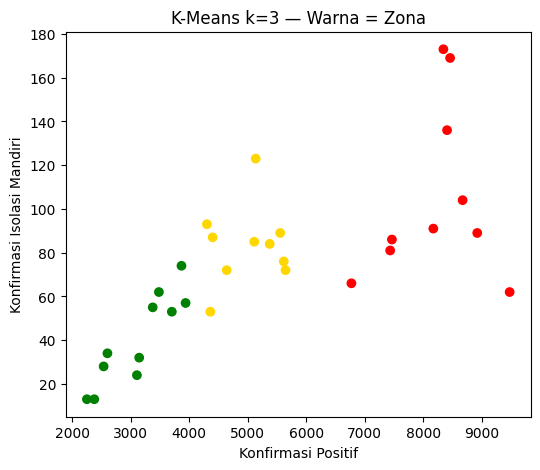

In [6]:
import matplotlib.pyplot as plt

color_map = {"Hijau":"green","Kuning":"gold","Merah":"red"}
plt.figure(figsize=(6,5))
plt.scatter(df_k3["Konfirmasi_Positif"], df_k3["Konfirmasi_Isolasi_Mandiri"], 
            c=df_k3["Zona"].map(color_map))
plt.xlabel("Konfirmasi Positif")
plt.ylabel("Konfirmasi Isolasi Mandiri")
plt.title("K-Means k=3 — Warna = Zona")
plt.show()
